In [8]:
# !git clone https://github.com/NotAbdelrahmanelsayed/energy-consumption-forcasting.git

This code imports essential libraries for a machine learning project involving LSTM neural networks for time series forecasting.

In [9]:
import pandas as pd
pd.set_option('display.float_format', lambda x:f'{x:.1f}')

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
tf.random.set_seed(42) # Fix random seed for reproducability.

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# 1. **EDA (Exploratory Data Analysis)**:
   - Read and inspect the dataset.
   - Rename columns for consistency.
   - Check and handle missing values.
   - Convert the date column to datetime format and set it as the index.
   - Visualize the data.

In [10]:
# Read the dataset
df = pd.read_csv('data/Alexandria - Weather Data.csv')
df.head()  # Display the first few rows

,Date,Ambient Temperature,wind_speed_10m (km/h),wind_speed_100m (km/h),Solar Radiation
0,2020-01-01T00:00,12.0,7.6,9.5,0.0
1,2020-01-01T01:00,12.2,6.0,14.0,0.0
2,2020-01-01T02:00,11.9,7.1,13.1,0.0
3,2020-01-01T03:00,12.2,6.4,15.0,0.0
4,2020-01-01T04:00,12.3,6.8,15.3,0.0


Rename features for consistincy.

In [11]:
# Rename features for consistency
renamed_features = {
    'Date ': 'date',
    'Ambient Temperature': 'ambient_temperature',
    'wind_speed_10m (km/h)': 'wind_speed_10m_kmh',
    'wind_speed_100m (km/h)': 'wind_speed_100m_kmh',
    'Solar Radiation': 'solar_radiation'
}
df.rename(columns=renamed_features, inplace=True)
df.head(2)  # Display the first two rows with renamed columns

,date,ambient_temperature,wind_speed_10m_kmh,wind_speed_100m_kmh,solar_radiation
0,2020-01-01T00:00,12.0,7.6,9.5,0.0
1,2020-01-01T01:00,12.2,6.0,14.0,0.0


In [12]:
# Print the shape of the data
print(f'The shape of our data is: {df.shape}')

The shape of our data is: (38616, 5)


Let's check for null values

In [13]:
df.isna().sum()

date                    0
ambient_temperature    24
wind_speed_10m_kmh     24
wind_speed_100m_kmh    24
solar_radiation        24
dtype: int64

In [14]:
df.tail(24)

,date,ambient_temperature,wind_speed_10m_kmh,wind_speed_100m_kmh,solar_radiation
38592,2024-05-27T00:00,NaN,NaN,NaN,NaN
38593,2024-05-27T01:00,NaN,NaN,NaN,NaN
38594,2024-05-27T02:00,NaN,NaN,NaN,NaN
38595,2024-05-27T03:00,NaN,NaN,NaN,NaN
38596,2024-05-27T04:00,NaN,NaN,NaN,NaN
38597,2024-05-27T05:00,NaN,NaN,NaN,NaN
38598,2024-05-27T06:00,NaN,NaN,NaN,NaN
38599,2024-05-27T07:00,NaN,NaN,NaN,NaN
38600,2024-05-27T08:00,NaN,NaN,NaN,NaN
38601,2024-05-27T09:00,NaN,NaN,NaN,NaN


Looks like the missing values are in the last 24 hours in the dataset. We can safely drop them.

In [15]:
# Drop the last 24 rows with missing values
df.dropna(axis=0, inplace=True)
df.isna().sum()  # Confirm there are no more missing values

date                   0
ambient_temperature    0
wind_speed_10m_kmh     0
wind_speed_100m_kmh    0
solar_radiation        0
dtype: int64

In [16]:
# Describe the dataset
df.describe()

,ambient_temperature,wind_speed_10m_kmh,wind_speed_100m_kmh,solar_radiation
count,38592.0,38592.0,38592.0,38592.0
mean,20.7,14.0,21.1,165.5
std,5.9,6.3,8.4,242.3
min,5.1,0.0,0.4,0.0
25%,15.8,9.0,15.8,0.0
50%,20.6,13.2,20.7,2.0
75%,25.3,18.1,25.6,300.0
max,42.8,50.4,69.4,864.0


![img.png](https://i.sstatic.net/EuitP.png)

In [17]:
# Convert date to datetime and set it as the index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

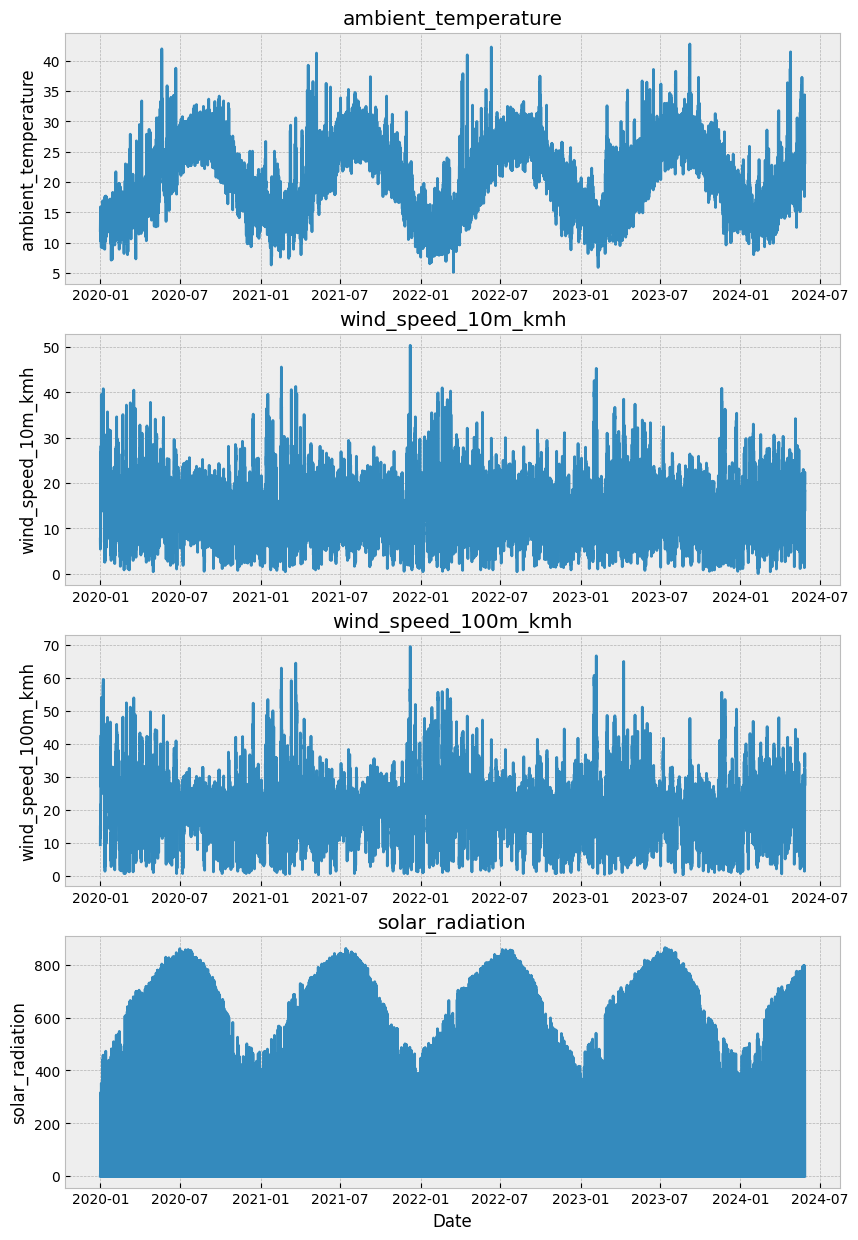

In [18]:
# Plot each column
fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(10, 15))
for ax, column in zip(axes, df.columns):
    ax.plot(df.index, df[column])
    ax.set_title(column)
    ax.set_ylabel(column)
    ax.grid(True)
axes[-1].set_xlabel('Date')
plt.show()

# 2. **Data Preprocessing**:
   - Split the dataset into training and testing sets.
   - Scale the dataset.
   - Prepare sequences for the LSTM model.

In [19]:
# Convert the dataset into numpy array
data = np.array(df)

In [20]:
# Scale the dataset
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [21]:
# Split into training and testing data
train_size = int(len(df) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

**prepare the dataset**

In [22]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length =  24
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# 3. **Model Training**:
   - Define and compile the LSTM model.
   - Train the model on the training data.

In [23]:
model = Sequential(
    [LSTM(100, return_sequences=True, input_shape=(sequence_length, 4)),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(4)]
)
print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 100)           42000     
                                                                 
 dropout (Dropout)           (None, 24, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 4)                 404       
                                                                 
Total params: 122,804
Trainable params: 122,804
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
386/386 [==============================] - 8s 13ms/step - loss: 0.0100 - val_loss: 0.0045
Epoch 2/10
386/386 [==============================] - 5s 12ms/step - loss: 0.0044 - val_loss: 0.0033
Epoch 3/10
386/386 [==============================] - 4s 12ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 4/10
386/386 [==============================] - 5s 12ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 5/10
386/386 [==============================] - 5s 12ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 6/10
386/386 [==============================] - 5s 12ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 7/10
386/386 [==============================] - 5s 12ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 8/10
386/386 [==============================] - 5s 12ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 9/10
386/386 [==============================] - 5s 12ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 10/10
386/386 [==============================] - 4s 11ms/step - loss: 0.0018 - val_lo

# 4. **Evaluation**:
   - Evaluate the model on the test data.
   - Plot the training and validation loss.
   - Make predictions on the test set.
   - Inverse scale the predictions and compare them with actual values.
   - Visualize the predictions vs. actual values for each feature.


In [25]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print('RMSE: ', np.sqrt(loss))

241/241 [==============================] - 1s 4ms/step - loss: 0.0013
Test Loss: 0.0013
RMSE:  0.03589386156407892


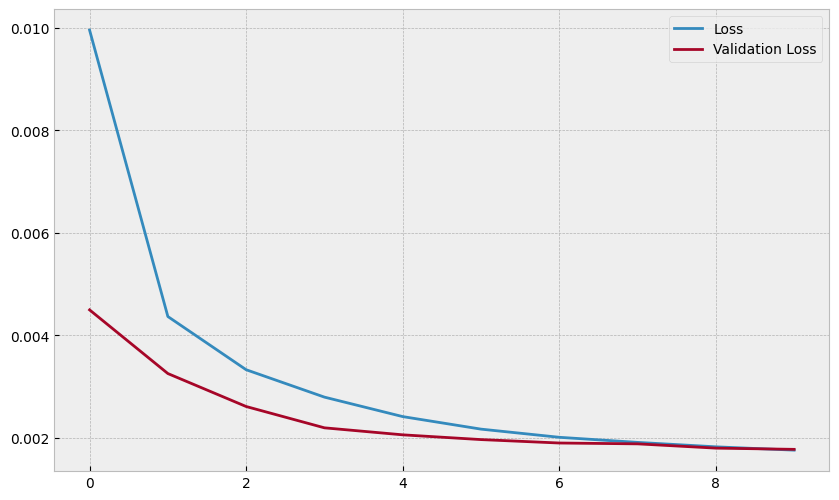

In [26]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Validation Loss'])
plt.show()


**Make predictions on the test set**


In [27]:
# Make predictions
predictions = model.predict(X_test)

# Inverse scale the predictions
predicted_values = scaler.inverse_transform(predictions)
actual_values = scaler.inverse_transform(y_test)

# Clip negative values to zero
predicted_values = np.clip(predicted_values, a_min=0, a_max=None)

241/241 [==============================] - 1s 4ms/step


In [28]:

# Compare predictions with actual values
comparison = pd.DataFrame({
    'Actual Temperature': actual_values[:, 0],
    'Predicted Temperature': predicted_values[:, 0],
    'Actual Wind Speed 10m': actual_values[:, 1],
    'Predicted Wind Speed 10m': predicted_values[:, 1],
    'Actual Wind Speed 100m': actual_values[:, 2],
    'Predicted Wind Speed 100m': predicted_values[:, 2],
    'Actual Solar Radiation': actual_values[:, 3],
    'Predicted Solar Radiation': predicted_values[:, 3],
})

comparison.head(20)

,Actual Temperature,Predicted Temperature,Actual Wind Speed 10m,Predicted Wind Speed 10m,Actual Wind Speed 100m,Predicted Wind Speed 100m,Actual Solar Radiation,Predicted Solar Radiation
0,32.5,31.6,17.3,17.6,20.7,20.6,770.0,757.6
1,33.0,31.9,18.7,18.9,22.7,22.4,837.0,815.0
2,32.8,32.0,21.0,19.5,25.6,23.4,845.0,827.8
3,32.2,31.6,22.5,21.3,27.4,25.8,793.0,777.7
4,32.0,31.1,22.1,21.7,27.7,26.3,685.0,672.9
5,31.5,30.6,22.4,21.1,28.0,25.5,532.0,514.2
6,30.4,29.8,22.0,20.9,28.6,25.9,353.0,323.3
7,28.7,28.9,20.2,19.7,27.6,26.2,168.0,150.7
8,26.9,27.8,16.7,17.3,24.9,25.5,32.0,33.8
9,26.2,26.7,15.2,14.2,24.6,23.1,0.0,0.0


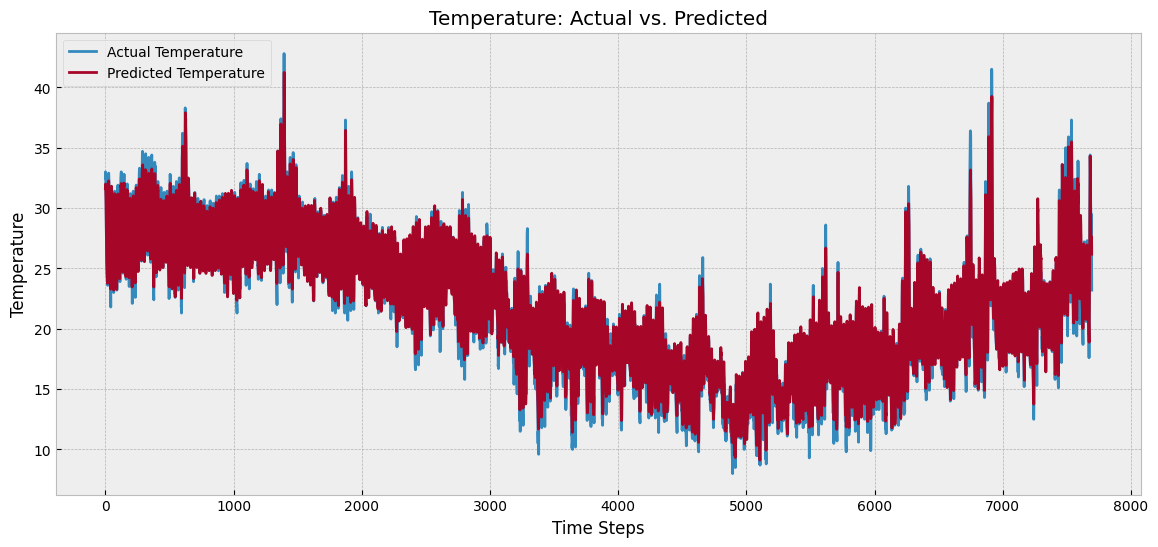

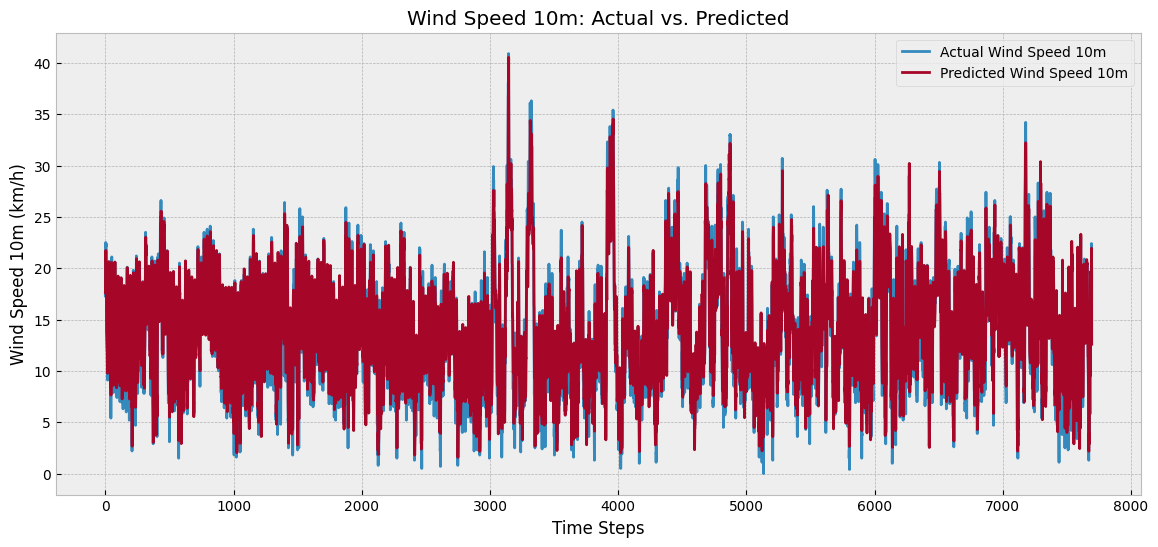

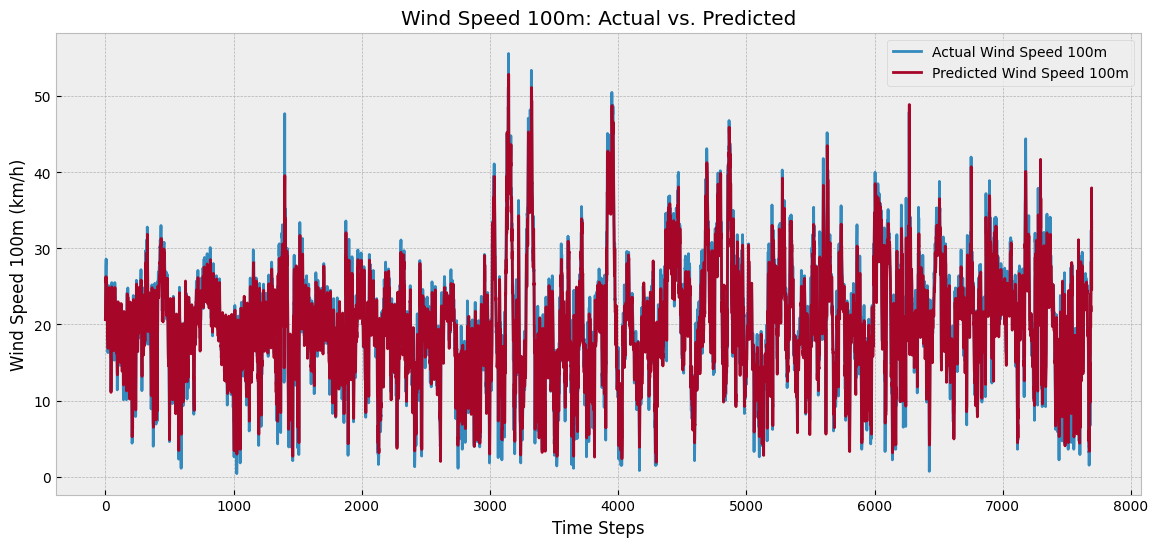

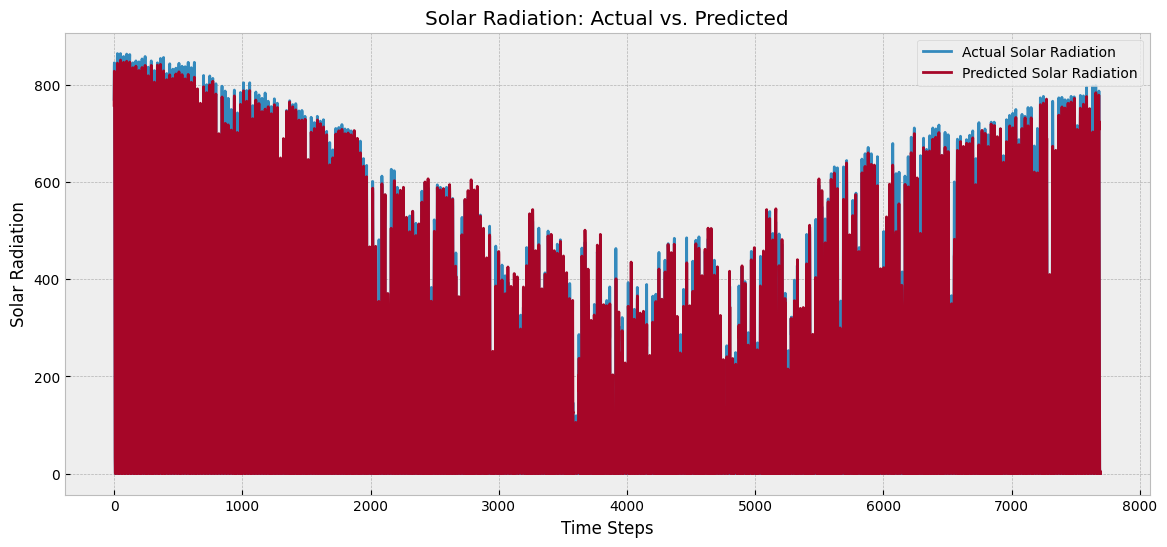

In [29]:

# Plot predictions vs. actual values for Temperature
plt.figure(figsize=(14, 6))
plt.plot(actual_values[:, 0], label='Actual Temperature')
plt.plot(predicted_values[:, 0], label='Predicted Temperature')
plt.title('Temperature: Actual vs. Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Plot predictions vs. actual values for Wind Speed 10m
plt.figure(figsize=(14, 6))
plt.plot(actual_values[:, 1], label='Actual Wind Speed 10m')
plt.plot(predicted_values[:, 1], label='Predicted Wind Speed 10m')
plt.title('Wind Speed 10m: Actual vs. Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Wind Speed 10m (km/h)')
plt.legend()
plt.show()

# Plot predictions vs. actual values for Wind Speed 100m
plt.figure(figsize=(14, 6))
plt.plot(actual_values[:, 2], label='Actual Wind Speed 100m')
plt.plot(predicted_values[:, 2], label='Predicted Wind Speed 100m')
plt.title('Wind Speed 100m: Actual vs. Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Wind Speed 100m (km/h)')
plt.legend()
plt.show()

# Plot predictions vs. actual values for Solar Radiation
plt.figure(figsize=(14, 6))
plt.plot(actual_values[:, 3], label='Actual Solar Radiation')
plt.plot(predicted_values[:, 3], label='Predicted Solar Radiation')
plt.title('Solar Radiation: Actual vs. Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Solar Radiation')
plt.legend()
plt.show()

In [30]:
# Create directory to save models
import os
if not os.path.exists('models'):
    os.makedirs('models')

# Save the model
model.save('models/final_model.h5')

# Save the model architecture to JSON
model_json = model.to_json()
with open("models/final_model.json", "w") as json_file:
    json_file.write(model_json)

# 5. **Final Training and Saving the Model**:
   - Train the model on the entire dataset.
   - Save the trained model in a folder named `models`.

In [23]:
# Prepare the entire dataset
X, y = create_sequences(data, sequence_length)

In [24]:
# Define the model
final_model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(sequence_length, 4)),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(4)
])

In [25]:
# Compile the model
final_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
final_history = final_model.fit(X, y, epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
483/483 [==============================] - 20s 32ms/step - loss: 0.0090 - val_loss: 0.0033
Epoch 2/10
483/483 [==============================] - 14s 29ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 3/10
483/483 [==============================] - 14s 30ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 4/10
483/483 [==============================] - 14s 30ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 5/10
483/483 [==============================] - 15s 30ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 6/10
483/483 [==============================] - 14s 29ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 7/10
483/483 [==============================] - 14s 29ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 8/10
483/483 [==============================] - 14s 30ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 9/10
483/483 [==============================] - 14s 30ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 10/10
483/483 [==============================] - 14s 29ms/step - loss: 0.001

In [26]:
# Create directory to save models
import os
if not os.path.exists('models'):
    os.makedirs('models')

# Save the model
final_model.save('models/final_model.h5')

# Save the model architecture to JSON
model_json = final_model.to_json()
with open("models/final_model.json", "w") as json_file:
    json_file.write(model_json)

# 6. **Load the trained model**

In [2]:
# Load the saved model
from tensorflow.keras.models import load_model
import json
from tensorflow.keras.models import model_from_json

# Load the model architecture from JSON
with open('models/final_model.json', 'r') as json_file:
    model_json = json_file.read()

# Recreate the model from the JSON file
loaded_model = model_from_json(model_json)

# Load the model weights
loaded_model.load_weights('models/final_model.h5')

# Compile the loaded model
loaded_model.compile(optimizer='adam', loss='mean_squared_error')

In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def read_data(data_path):
    # Read the dataset
    df = pd.read_csv(data_path)

    # Rename features for consistency
    renamed_features = {
        'Date ': 'date',
        'Ambient Temperature': 'ambient_temperature',
        'wind_speed_10m (km/h)': 'wind_speed_10m_kmh',
        'wind_speed_100m (km/h)': 'wind_speed_100m_kmh',
        'Solar Radiation': 'solar_radiation'
    }
    df.rename(columns=renamed_features, inplace=True)

    # Drop rows with missing values
    df.dropna(axis=0, inplace=True)

    # Convert date to datetime and set it as the index
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    # Convert the dataset into numpy array
    data = np.array(df)

    # Scale the dataset
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)

    # Debugging: Check the scaled data
    print("Scaled data:")
    print(data[:5])
    
    return data, scaler, df.index

def create_sequences(data, sequence_length):
    X = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
    
    # Debugging: Print the shape of the sequences
    print(f"Created sequences with shape: {np.array(X).shape}")
    
    return np.array(X)

def generate_future_predictions(model, initial_sequence, num_predictions):
    predictions = []
    current_sequence = initial_sequence

    for _ in range(num_predictions):
        prediction = model.predict(current_sequence[np.newaxis, :, :])
        predictions.append(prediction.flatten())
        current_sequence = np.append(current_sequence[1:], prediction, axis=0)

    # Debugging: Print the shape and first few predictions
    print(f"Generated predictions with shape: {np.array(predictions).shape}")
    print(f"First few predictions: {predictions[:5]}")
    
    return np.array(predictions)

def generate_future_dates(last_date, num_days):
    return pd.date_range(start=last_date, periods=num_days + 1, inclusive='right')


# Main script
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load original data and scaler
data_path = 'data/Alexandria - Weather Data.csv'
data, scaler, dates = read_data(data_path)

sequence_length = 24
X = create_sequences(data, sequence_length)

# Load the saved model
model = load_model('models/final_model.h5')

# Generate predictions for the next X*24 days where X is the number of days
initial_sequence = data[-sequence_length:]

# Debugging: Print initial sequence
print("Initial sequence for predictions:\n", initial_sequence)

num_predictions = 14 * 24
future_predictions = generate_future_predictions(model, initial_sequence, num_predictions)
future_predictions = scaler.inverse_transform(future_predictions)
future_predictions = np.clip(future_predictions, a_min=0, a_max=None)

# Generate future dates
last_date = dates[-1]
future_dates = pd.date_range(start=last_date, periods=num_predictions, freq='H')

# Combine original and predicted data
historical_data = scaler.inverse_transform(data)  # Inverse transform historical data
all_dates = np.concatenate([dates, future_dates])
combined_data = np.concatenate([historical_data, future_predictions])

# Debugging: Print combined data
print("Combined data shape:", combined_data.shape)
print("First few combined data rows:\n", combined_data[:5])

# Create DataFrame for combined data
df_combined = pd.DataFrame(
    combined_data,
    columns=['Temperature', 'Wind Speed 10m', 'Wind Speed 100m', 'Solar Radiation'],
    index=all_dates
)

# Save the new predictions with dates
df_combined.to_csv('results/predictions.csv', index=False)

# Plot settings
plt.style.use('bmh')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Historical and Predicted Data', fontsize=16)

# Plot each feature
features = ['Temperature', 'Wind Speed 10m', 'Wind Speed 100m', 'Solar Radiation']
colors = ['#17becf', '#2ca02c']  # Colors for historical and predicted data

for ax, feature in zip(axes.flatten(), features):
    # Plot historical data
    ax.plot(df_combined.index[:len(historical_data)], df_combined[feature][:len(historical_data)], color=colors[0], label='Historical data')
    
    # Plot predicted data
    ax.plot(df_combined.index[len(historical_data):], df_combined[feature][len(historical_data):], color=colors[1], label='Predicted data')
    
    # Highlight the transition point with a vertical line
    ax.axvline(x=df_combined.index[len(historical_data)], color='black', linestyle='--')
    
    # Set the title and labels
    ax.set_title(feature)
    ax.set_xlabel('Time (h)')
    ax.set_ylabel(feature)
    
    # Add a legend
    ax.legend()

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Scaled data:
[[0.18302387 0.15079365 0.13188406 0.        ]
 [0.18832891 0.11904762 0.19710145 0.        ]
 [0.18037135 0.14087302 0.18405797 0.        ]
 [0.18832891 0.12698413 0.2115942  0.        ]
 [0.19098143 0.13492063 0.21594203 0.        ]]
Created sequences with shape: (38568, 24, 4)
Initial sequence for predictions:
 []


ValueError: in user code:

    File "c:\Users\bedo7\.conda\envs\mlops\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\bedo7\.conda\envs\mlops\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\bedo7\.conda\envs\mlops\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\bedo7\.conda\envs\mlops\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\bedo7\.conda\envs\mlops\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\bedo7\.conda\envs\mlops\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 24, 4), found shape=(None, 0, 4)


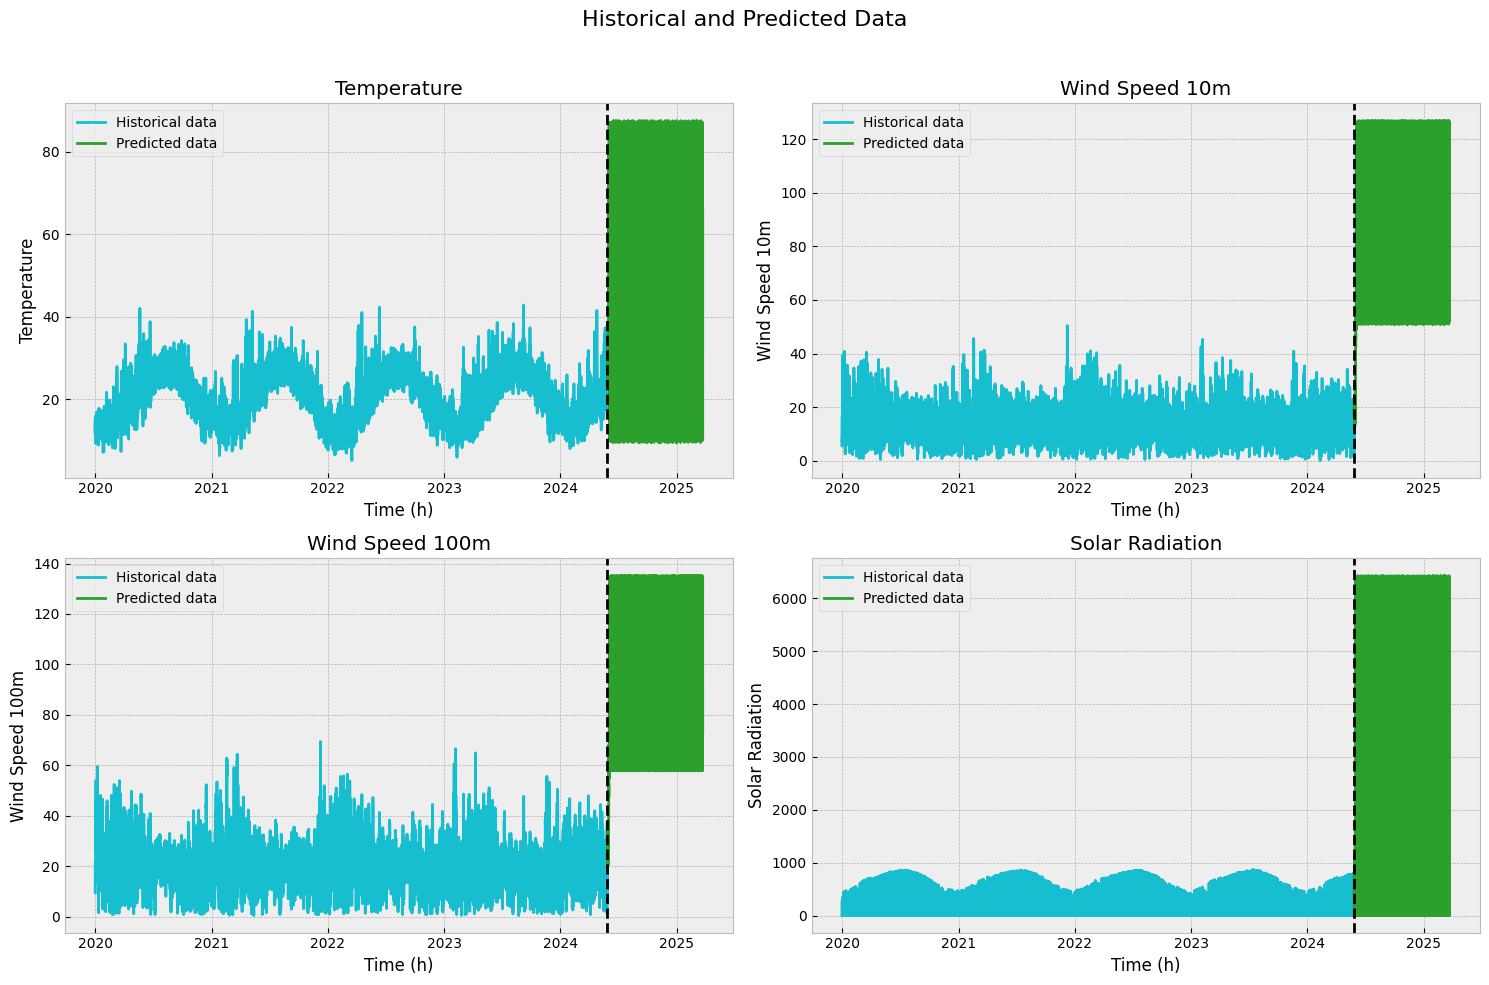

In [5]:
import matplotlib.pyplot as plt

# Plot settings
plt.style.use('bmh')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Historical and Predicted Data', fontsize=16)

# Plot each feature
features = ['Temperature', 'Wind Speed 10m', 'Wind Speed 100m', 'Solar Radiation']
colors = ['#17becf', '#2ca02c']  # Colors for historical and predicted data

for ax, feature in zip(axes.flatten(), features):
    # Plot historical data
    ax.plot(df_combined.index[:len(historical_data)], df_combined[feature][:len(historical_data)], color=colors[0], label='Historical data')
    
    # Plot predicted data
    ax.plot(df_combined.index[len(historical_data):], df_combined[feature][len(historical_data):], color=colors[1], label='Predicted data')
    
    # Highlight the transition point with a vertical line
    ax.axvline(x=df_combined.index[len(historical_data)], color='black', linestyle='--')
    
    # Set the title and labels
    ax.set_title(feature)
    ax.set_xlabel('Time (h)')
    ax.set_ylabel(feature)
    
    # Add a legend
    ax.legend()

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
